In [35]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load QM9 CSV
df = pd.read_csv("qm9_.csv")

# Subset the data for quick testing
subset_size = 500  # You can change this to 1000, 10000, etc.       133883 size of full dataset
df = df.dropna(subset=["homo", "lumo", "gap", "alpha"]).sample(n=subset_size, random_state=42).reset_index(drop=True)

# Extract SMILES and targets
target_columns = ["homo", "lumo", "gap", "alpha"]
smiles_list = df["smiles"].tolist()
target_props = df[target_columns].values

# Normalize targets
scaler = StandardScaler()
target_props = scaler.fit_transform(target_props)

# Train/test split
train_smiles, test_smiles, train_y, test_y = train_test_split(smiles_list, target_props, test_size=0.2, random_state=42)



In [37]:
class SMILESTokenizer:
    def __init__(self):
        self.special = ['<pad>', '<bos>', '<eos>', '<unk>']
        self.vocab = {tok: idx for idx, tok in enumerate(self.special)}

    def tokenize(self, smiles):
        return list(smiles)

    def build_vocab(self, smiles_list):
        chars = set(c for smi in smiles_list for c in self.tokenize(smi))
        for c in sorted(chars):
            if c not in self.vocab:
                self.vocab[c] = len(self.vocab)

        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, smiles, max_len=128):
        tokens = self.tokenize(smiles)
        ids = [self.vocab.get(tok, self.vocab['<unk>']) for tok in tokens]
        ids = [self.vocab['<bos>']] + ids[:max_len-2] + [self.vocab['<eos>']]
        ids += [self.vocab['<pad>']] * (max_len - len(ids))
        return torch.tensor(ids)

    def vocab_size(self):
        return len(self.vocab)

tokenizer = SMILESTokenizer()
tokenizer.build_vocab(train_smiles + test_smiles)

In [38]:
from torch.utils.data import Dataset, DataLoader
import torch

class QM9Dataset(Dataset):
    def __init__(self, smiles, targets, tokenizer):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = self.tokenizer.encode(self.smiles[idx])
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

train_dataset = QM9Dataset(train_smiles, train_y, tokenizer)
test_dataset = QM9Dataset(test_smiles, test_y, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [39]:
import torch.nn as nn

class TransformerRegressor(nn.Module):
    def __init__(self, vocab_size, seq_len, dim=256, heads=16, depth=6, ff_mult=2, n_outputs=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 8)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, 8))
        self.proj = nn.Linear(8, dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=ff_mult*dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.ReLU(),
            nn.Linear(dim // 2, n_outputs)
        )

    def forward(self, x):
        x = self.embed(x) + self.pos_embed[:, :x.size(1), :]
        x = self.proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # average pooling
        return self.head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(tokenizer.vocab_size(), seq_len=128).to(device)

In [40]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]"):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)




# for epoch in range(3):
#     model.train()
#     total_loss = 0
#     for x, y in tqdm(train_loader):
#         x, y = x.to(device), y.to(device)
#         pred = model(x)
#         loss = loss_fn(pred, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

Epoch 5 [Test]: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


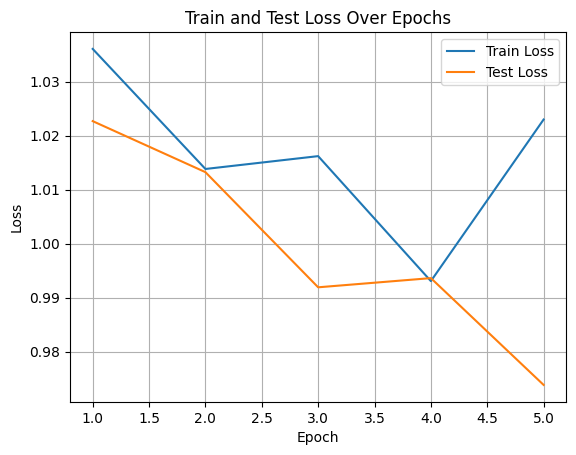

In [41]:
import matplotlib.pyplot as plt

# Plot losses
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

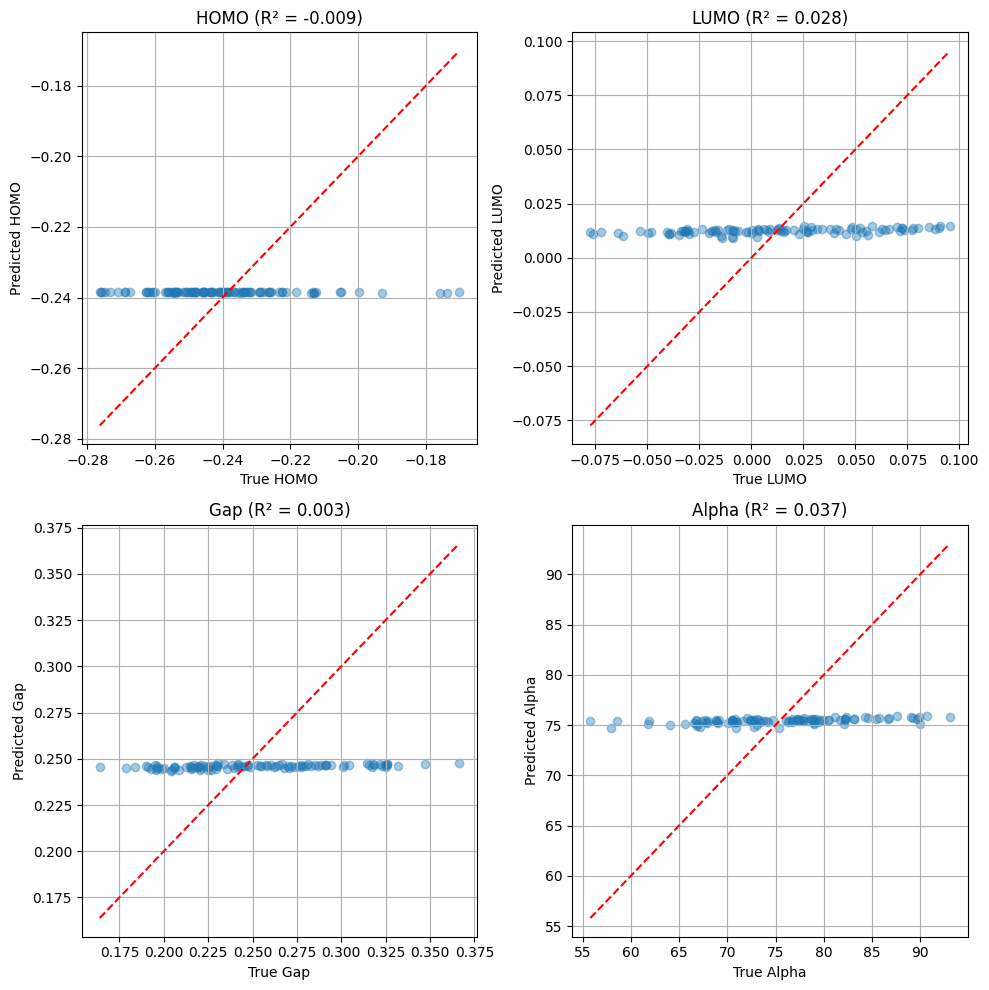

In [42]:
from sklearn.metrics import r2_score

model.eval()
preds, truths = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x)
        preds.append(pred.cpu())
        truths.append(y)

preds = torch.cat(preds).numpy()
truths = torch.cat(truths).numpy()

# Inverse transform targets
preds = scaler.inverse_transform(preds)
truths = scaler.inverse_transform(truths)

# Plot setup
labels = ["HOMO", "LUMO", "Gap", "Alpha"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    r2 = r2_score(truths[:, i], preds[:, i])
    axs[i].scatter(truths[:, i], preds[:, i], alpha=0.4)
    axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                [truths[:, i].min(), truths[:, i].max()], 'r--')
    axs[i].set_xlabel(f"True {labels[i]}")
    axs[i].set_ylabel(f"Predicted {labels[i]}")
    axs[i].set_title(f"{labels[i]} (R² = {r2:.3f})")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Autoregressive Transformer

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
RDKIT_AVAILABLE = True

In [44]:
# --- Configuration ---
# Model Parameters (as specified by user)
D_MODEL = 256  # Channels
N_HEADS = 8
D_FF = 1024  # Feedforward Multiplier 4 -> 256 * 4 = 1024
SMILES_EMBEDDING_DIM = 16 # Embedding Dimension for SMILES tokens
# CROSS_ATTENTION_EMBEDDING_DIM = 8 # Not directly used as k/v dim for simplicity, see notes.
MAX_SEQ_LEN = 128  # Maximum SMILES sequence length
DECODER_DEPTH = 6  # Number of decoder layers
PROPERTY_DIM = 4  # homo, lumo, gap, alpha
DROPOUT = 0.1

# Training Parameters (example values)
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 3 # Placeholder: actual training needs more
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Special Tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>" # Start of Sequence
EOS_TOKEN = "<eos>" # End of Sequence
UNK_TOKEN = "<unk>" # Unknown token

In [45]:
# --- SMILES Tokenizer ---
class SMILESTokenizer:
    def __init__(self):
        self.special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0

    def fit(self, smiles_list):
        # Gathers all unique characters from SMILES strings
        all_chars = set()
        for smiles in smiles_list:
            for char in smiles:
                all_chars.add(char)
        
        # Sort characters for consistent mapping
        sorted_chars = sorted(list(all_chars))
        
        # Initialize with special tokens
        self.char_to_idx = {token: i for i, token in enumerate(self.special_tokens)}
        current_idx = len(self.special_tokens)
        
        # Add unique SMILES characters
        for char in sorted_chars:
            if char not in self.char_to_idx: # Should not happen if special tokens are not in SMILES chars
                self.char_to_idx[char] = current_idx
                current_idx += 1
        
        self.idx_to_char = {i: char for char, i in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Ensure special tokens have correct indices
        self.pad_idx = self.char_to_idx[PAD_TOKEN]
        self.sos_idx = self.char_to_idx[SOS_TOKEN]
        self.eos_idx = self.char_to_idx[EOS_TOKEN]
        self.unk_idx = self.char_to_idx[UNK_TOKEN]

    def tokenize(self, smiles_string):
        # Converts a SMILES string to a list of token IDs
        return [self.char_to_idx.get(char, self.unk_idx) for char in smiles_string]

    def detokenize(self, token_ids):
        # Converts a list of token IDs back to a SMILES string
        chars = []
        for token_id in token_ids:
            if token_id == self.eos_idx:
                break
            if token_id not in [self.sos_idx, self.pad_idx]: # Don't include SOS or PAD in output string
                 chars.append(self.idx_to_char.get(token_id, UNK_TOKEN))
        return "".join(chars)


In [46]:

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=MAX_SEQ_LEN):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe) # Not a model parameter

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # self.pe shape: (1, max_len, d_model)
        # We need to select the relevant part of pe: self.pe[:, :x.size(1), :]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [47]:
# --- Transformer Model ---
class SmilesTransformer(nn.Module):
    def __init__(self, vocab_size, property_dim, d_model, n_heads, d_ff,
                 decoder_depth, smiles_embedding_dim, max_seq_len, dropout, pad_idx): # Added pad_idx
        super(SmilesTransformer, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.property_projector = nn.Linear(property_dim, d_model)
        self.smiles_embedder = nn.Embedding(vocab_size, smiles_embedding_dim, padding_idx=pad_idx) # Use passed pad_idx
        self.smiles_input_projector = nn.Linear(smiles_embedding_dim, d_model)
        self.positional_encoder = PositionalEncoding(d_model, dropout, max_seq_len)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, activation='relu', batch_first=True, norm_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_depth)
        self.output_layer = nn.Linear(d_model, vocab_size)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(DEVICE)

    def forward(self, properties, tgt_smiles_tokens, tgt_padding_mask=None):
        memory = self.property_projector(properties).unsqueeze(1) 
        tgt_embed = self.smiles_embedder(tgt_smiles_tokens)
        tgt_projected = self.smiles_input_projector(tgt_embed) * math.sqrt(self.d_model)
        tgt_pos_encoded = self.positional_encoder(tgt_projected)
        tgt_mask = self._generate_square_subsequent_mask(tgt_smiles_tokens.size(1))
        decoder_output = self.transformer_decoder(
            tgt=tgt_pos_encoded, memory=memory,
            tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask
        )
        return self.output_layer(decoder_output)

    def generate(self, properties, tokenizer, max_len=MAX_SEQ_LEN):
        self.eval()
        if properties.ndim == 1:
            properties = properties.unsqueeze(0)
        properties = properties.to(DEVICE)
        generated_ids = torch.tensor([[tokenizer.sos_idx]], dtype=torch.long, device=DEVICE)
        memory = self.property_projector(properties).unsqueeze(1)

        with torch.no_grad():
            for _ in range(max_len - 1):
                tgt_embed = self.smiles_embedder(generated_ids)
                tgt_projected = self.smiles_input_projector(tgt_embed) * math.sqrt(self.d_model)
                tgt_pos_encoded = self.positional_encoder(tgt_projected)
                tgt_mask = self._generate_square_subsequent_mask(generated_ids.size(1))
                decoder_output = self.transformer_decoder(tgt=tgt_pos_encoded, memory=memory, tgt_mask=tgt_mask)
                last_token_logits = self.output_layer(decoder_output[:, -1, :])
                predicted_id = torch.argmax(last_token_logits, dim=-1).unsqueeze(1)
                generated_ids = torch.cat([generated_ids, predicted_id], dim=1)
                if predicted_id.item() == tokenizer.eos_idx:
                    break
        return tokenizer.detokenize(generated_ids.squeeze(0).cpu().tolist())


In [48]:
# --- Wrapper for your TransformerRegressor (SMILES -> Property) ---
# Place this class definition in a new cell after your TransformerRegressor 
# and SMILESTokenizer class definitions.

class ForwardPropertyPredictorWrapper:
    def __init__(self, smiles_to_prop_model, tokenizer, scaler, property_names, device, max_seq_len_pred_model):
        """
        Wrapper for your TransformerRegressor to make it compatible.

        Args:
            smiles_to_prop_model: Your trained TransformerRegressor instance (from cell 5, trained in cell 7).
            tokenizer: Your SMILESTokenizer instance (from cell 3 or 12).
            scaler: StandardScaler instance fitted on the property_names.
            property_names (list): List of property names in the order the model predicts 
                                   and the scaler expects (e.g., ["homo", "lumo", "gap", "alpha"]).
            device: The torch device (e.g., torch.device("cpu")).
            max_seq_len_pred_model (int): The max sequence length your TransformerRegressor expects.
        """
        self.model = smiles_to_prop_model
        self.tokenizer = tokenizer
        self.scaler = scaler
        self.property_names = property_names
        self.device = device
        self.max_seq_len = max_seq_len_pred_model

    def predict_properties(self, smiles_string):
        """
        Predicts properties for a given SMILES string.

        Args:
            smiles_string (str): The SMILES string to predict properties for.

        Returns:
            dict: A dictionary of predicted (unscaled) properties.
        """
        self.model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            # Tokenize the SMILES string using the 'encode' method from your SMILESTokenizer
            # This method should handle adding <bos>, <eos> and padding to max_seq_len.
            # (as per your cell 3 or cell 12 tokenizer and cell 4 QM9Dataset)
            token_ids = self.tokenizer.encode(smiles_string, max_len=self.max_seq_len)
            
            # Add batch dimension and move to device
            input_tensor = token_ids.unsqueeze(0).to(self.device) 

            # Get scaled predictions from your TransformerRegressor
            # Your model's forward pass (cell 5) takes x (tokenized SMILES)
            scaled_predictions_tensor = self.model(input_tensor) # Shape: (1, num_properties)
            
            # Inverse transform to get unscaled properties
            # The scaler expects a 2D array (n_samples, n_features)
            unscaled_predictions_np = self.scaler.inverse_transform(scaled_predictions_tensor.cpu().numpy())
            
            # Return as a dictionary with property names as keys
            return dict(zip(self.property_names, unscaled_predictions_np.squeeze()))

    def eval(self): # For consistency if the main function calls eval on it
        self.model.eval()

In [49]:
# --- Dataset and DataLoader ---
class QM9Dataset(Dataset):
    def __init__(self, properties_df, smiles_list, tokenizer, max_seq_len):
        self.properties = torch.tensor(properties_df.values, dtype=torch.float)
        self.smiles_list = smiles_list
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        props = self.properties[idx]
        smiles = self.smiles_list[idx]

        # Tokenize SMILES: <sos> + tokens + <eos>
        tokenized_smiles = [self.tokenizer.sos_idx] + self.tokenizer.tokenize(smiles) + [self.tokenizer.eos_idx]
        
        # Pad or truncate
        if len(tokenized_smiles) < self.max_seq_len:
            padding = [self.tokenizer.pad_idx] * (self.max_seq_len - len(tokenized_smiles))
            tokenized_smiles.extend(padding)
        else:
            tokenized_smiles = tokenized_smiles[:self.max_seq_len -1] + [self.tokenizer.eos_idx] # Ensure EOS if truncated

        # Input to decoder: <sos> t1 t2 ... tn-1 <pad> ...
        # Target for loss:   t1 t2 ... tn-1 <eos> <pad> ...
        # Both should have length max_seq_len
        
        # Decoder input sequence (starts with SOS, ends before final EOS if full, or with PADs)
        # Example: if tokenized_smiles = [sos, t1, t2, eos, pad, pad] (len 6, max_len 6)
        # input_seq = [sos, t1, t2, eos, pad] (remove last, for predicting next)
        # target_seq = [t1, t2, eos, pad, pad] (remove first)

        input_seq = torch.tensor(tokenized_smiles[:-1], dtype=torch.long)
        target_seq = torch.tensor(tokenized_smiles[1:], dtype=torch.long) # Shifted right

        # Create padding mask for the input sequence (True where it's a pad token)
        # This is for tgt_key_padding_mask in TransformerDecoder
        padding_mask = (input_seq == self.tokenizer.pad_idx)

        return props, input_seq, target_seq, padding_mask


In [50]:
# --- Generation and Evaluation ---
def generate_new_sequences(model, tokenizer, scaler, target_properties_unscaled_list, qm9_smiles_set, property_names):
    """
    Generates SMILES sequences for given target properties, checks against QM9,
    and visualizes them.
    Args:
        model: The trained SmilesTransformer model.
        tokenizer: The SMILESTokenizer.
        scaler: The fitted StandardScaler for properties.
        target_properties_unscaled_list (list of dicts): List of dictionaries, 
            each with unscaled property values (e.g., {'homo': -7.0, 'lumo': -1.0, 'gap': 6.0, 'alpha': 75.0}).
            Must contain 'gap' and 'alpha'. Other properties will be used if present, otherwise
            defaults might be needed or an error raised if not all 4 are present.
        qm9_smiles_set (set): A set of SMILES strings from the QM9 dataset for quick lookup.
        property_names (list): List of property names in the order expected by the scaler and model.
    Returns:
        list of dicts: Each dict contains 'target_properties_unscaled', 
                       'target_properties_scaled', 'generated_smiles', 
                       'is_in_qm9', 'is_valid_rdkit', 'mol_image_path'.
    """
    generated_results = []
    output_dir = "generated_molecules"
    os.makedirs(output_dir, exist_ok=True)

    for i, props_unscaled_dict in enumerate(target_properties_unscaled_list):
        print(f"\nGenerating for target (unscaled): {props_unscaled_dict}")

        # Ensure all required properties are present and in correct order for scaling
        current_props_unscaled = np.array([props_unscaled_dict.get(p_name, 0) for p_name in property_names])
        
        # Scale the properties
        props_scaled = scaler.transform(current_props_unscaled.reshape(1, -1))
        props_tensor = torch.tensor(props_scaled.squeeze(), dtype=torch.float).to(DEVICE)

        # Generate SMILES
        smiles_gen = model.generate(props_tensor, tokenizer, max_len=MAX_SEQ_LEN)
        
        is_in_qm9 = smiles_gen in qm9_smiles_set
        is_valid_rdkit = False
        mol_image_path = None

        if RDKIT_AVAILABLE and smiles_gen:
            mol = Chem.MolFromSmiles(smiles_gen)
            if mol:
                is_valid_rdkit = True
                try:
                    img = MolsToGridImage([mol], molsPerRow=1, subImgSize=(200,200))
                    mol_image_path = os.path.join(output_dir, f"generated_{i+1}.png")
                    # MolsToGridImage returns a PIL image. To save it:
                    # For this, you might need PIL (Pillow) if not already a dep of rdkit/matplotlib
                    # from PIL import Image (handled by MolsToGridImage if it creates an image object)
                    # For simplicity, let's assume MolsToGridImage can save or we use a simpler Draw.MolToImage
                    from rdkit.Chem.Draw import MolToFile
                    MolToFile(mol, mol_image_path, size=(300,300))
                    print(f"Visualized and saved to: {mol_image_path}")
                except Exception as e:
                    print(f"Error visualizing SMILES '{smiles_gen}': {e}")
                    mol_image_path = None # Reset on error
            else:
                print(f"Generated SMILES '{smiles_gen}' is not valid according to RDKit.")
        
        result = {
            'target_properties_unscaled': props_unscaled_dict,
            'target_properties_scaled': props_scaled.squeeze().tolist(),
            'generated_smiles': smiles_gen,
            'is_in_qm9': is_in_qm9,
            'is_valid_rdkit': is_valid_rdkit,
            'mol_image_path': mol_image_path
        }
        generated_results.append(result)

        print(f"Generated SMILES: {smiles_gen}")
        print(f"Is in QM9: {is_in_qm9}")
        print(f"RDKit valid: {is_valid_rdkit}")
        
    return generated_results

def plot_target_property_performance(generated_results, property_x='gap', property_y='alpha'):
    """
    Plots the target properties (e.g., gap vs alpha) for the generated sequences.
    Args:
        generated_results (list of dicts): Output from generate_new_sequences.
        property_x (str): Name of the property for the x-axis.
        property_y (str): Name of the property for the y-axis.
    """
    if not generated_results:
        print("No results to plot.")
        return

    x_values = [res['target_properties_unscaled'][property_x] for res in generated_results]
    y_values = [res['target_properties_unscaled'][property_y] for res in generated_results]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, c='blue', alpha=0.7, label='Target Properties for Generation')
    plt.xlabel(f"Target {property_x.capitalize()} (unscaled)")
    plt.ylabel(f"Target {property_y.capitalize()} (unscaled)")
    plt.title(f"Target Performance of Generated Molecules ({property_y.capitalize()} vs {property_x.capitalize()})")
    plt.legend()
    plt.grid(True)
    plot_filename = "target_properties_plot.png"
    plt.savefig(plot_filename)
    print(f"Target properties plot saved to {plot_filename}")
    # plt.show() # Uncomment if running in an environment that supports interactive plots

In [51]:
try:
    df_full = pd.read_csv("qm9_.csv")
    print(f"Successfully loaded qm9_.csv. Shape: {df_full.shape}")
except FileNotFoundError:
    print("Error: qm9_.csv not found. Please ensure the file is in the correct directory.")

# Drop rows with NaNs in specified property columns
property_cols = ["homo", "lumo", "gap", "alpha"]
df_full = df_full.dropna(subset=property_cols)
print(f"Shape after dropping NaNs: {df_full.shape}")

if df_full.empty:
    print("DataFrame is empty after dropping NaNs. Cannot proceed.")
    exit()

# Create a set of existing SMILES for quick lookup
qm9_smiles_set = set(df_full['smiles'].tolist())

Successfully loaded qm9_.csv. Shape: (133885, 13)
Shape after dropping NaNs: (133885, 13)


In [52]:
# Filter for "high performing" molecules (e.g., top 25% in gap and alpha)
# You might want to adjust these quantiles
percentile = 0.95 # make 0.75 when ready to train
gap_threshold = df_full['gap'].quantile(percentile)
alpha_threshold = df_full['alpha'].quantile(percentile)

df_filtered = df_full[
    (df_full['gap'] >= gap_threshold) & \
    (df_full['alpha'] >= alpha_threshold)
].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Shape after filtering for high gap/alpha: {df_filtered.shape}")

if df_filtered.empty:
    print("DataFrame is empty after filtering for high gap/alpha. Try adjusting thresholds or check data.")
    exit()

Shape after filtering for high gap/alpha: (1493, 13)


In [ ]:
from torch.utils.data import random_split

# Normalize properties (already done)
scaler = StandardScaler()
df_filtered.loc[:, property_cols] = scaler.fit_transform(df_filtered[property_cols])

# Extract properties and SMILES
properties_data = df_filtered[property_cols]
smiles_data = df_filtered['smiles'].tolist()

# Initialize and fit tokenizer
tokenizer = SMILESTokenizer()
tokenizer.fit(smiles_data)
print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")
print(f"PAD index: {tokenizer.pad_idx}, SOS index: {tokenizer.sos_idx}, EOS index: {tokenizer.eos_idx}")

# Create dataset
qm9_dataset = QM9Dataset(properties_data, smiles_data, tokenizer, MAX_SEQ_LEN)

# 🔥 Split into training and test datasets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(qm9_dataset))
test_size = len(qm9_dataset) - train_size
train_dataset, test_dataset = random_split(qm9_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



Tokenizer vocabulary size: 13
PAD index: 0, SOS index: 1, EOS index: 2


In [54]:
# 4. Initialize Model, Optimizer, Loss
model = SmilesTransformer(
    vocab_size=tokenizer.vocab_size,
    property_dim=PROPERTY_DIM,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    decoder_depth=DECODER_DEPTH,
    smiles_embedding_dim=SMILES_EMBEDDING_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout=DROPOUT,
    pad_idx=tokenizer.pad_idx # Pass pad_idx explicitly
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Use CrossEntropyLoss, ignore padding index in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_idx)

import matplotlib.pyplot as plt

# Store losses
train_losses = []
test_losses = []

# Define an evaluation function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for props, input_seqs, target_seqs, padding_masks in data_loader:
            props = props.to(DEVICE)
            input_seqs = input_seqs.to(DEVICE)
            target_seqs = target_seqs.to(DEVICE)
            padding_masks = padding_masks.to(DEVICE)

            output_logits = model(props, input_seqs, tgt_padding_mask=padding_masks)
            loss = criterion(output_logits.reshape(-1, tokenizer.vocab_size), target_seqs.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(data_loader)

# Training loop
print(f"\n--- Starting Training Loop (for {NUM_EPOCHS} epochs) ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (props, input_seqs, target_seqs, padding_masks) in enumerate(train_loader):  # <- make sure this is your train DataLoader
        props = props.to(DEVICE)
        input_seqs = input_seqs.to(DEVICE)
        target_seqs = target_seqs.to(DEVICE)
        padding_masks = padding_masks.to(DEVICE)

        optimizer.zero_grad()
        output_logits = model(props, input_seqs, tgt_padding_mask=padding_masks)
        loss = criterion(output_logits.reshape(-1, tokenizer.vocab_size), target_seqs.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set (replace `test_loader` with your actual DataLoader)
    avg_test_loss = evaluate(model, test_loader, criterion)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed. Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print("--- Training Loop Finished ---")


--- Starting Training Loop (for 3 epochs) ---


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/3], Batch [1/38], Loss: 9.5416
Epoch [1/3], Batch [6/38], Loss: 3.2741
Epoch [1/3], Batch [11/38], Loss: 3.0733
Epoch [1/3], Batch [16/38], Loss: 2.5214
Epoch [1/3], Batch [21/38], Loss: 2.1824
Epoch [1/3], Batch [26/38], Loss: 2.1718
Epoch [1/3], Batch [31/38], Loss: 2.1203
Epoch [1/3], Batch [36/38], Loss: 1.9575
Epoch [1/3] completed. Train Loss: 2.8872, Test Loss: 1.2894
Epoch [2/3], Batch [1/38], Loss: 1.7612
Epoch [2/3], Batch [6/38], Loss: 1.7334
Epoch [2/3], Batch [11/38], Loss: 1.6884
Epoch [2/3], Batch [16/38], Loss: 1.7801
Epoch [2/3], Batch [21/38], Loss: 1.6262
Epoch [2/3], Batch [26/38], Loss: 1.6090
Epoch [2/3], Batch [31/38], Loss: 1.6440
Epoch [2/3], Batch [36/38], Loss: 1.4951
Epoch [2/3] completed. Train Loss: 1.6780, Test Loss: 1.0968
Epoch [3/3], Batch [1/38], Loss: 1.4698
Epoch [3/3], Batch [6/38], Loss: 1.4482
Epoch [3/3], Batch [11/38], Loss: 1.5223
Epoch [3/3], Batch [16/38], Loss: 1.5782
Epoch [3/3], Batch [21/38], Loss: 1.5603
Epoch [3/3], Batch [26/

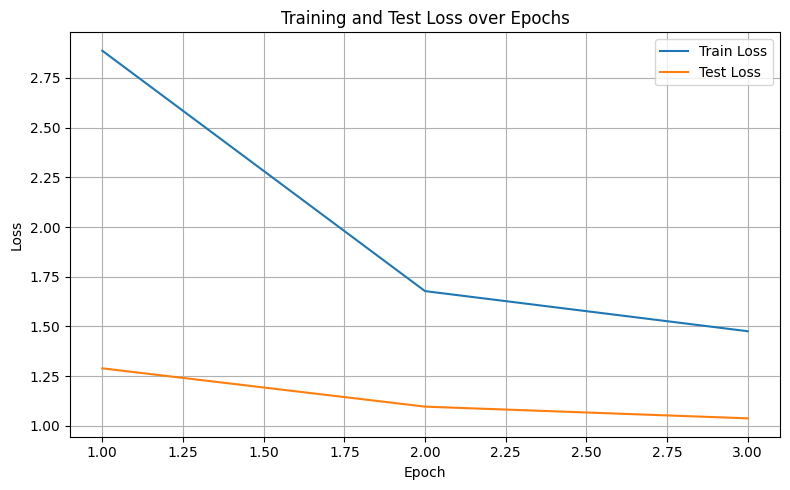

In [55]:
# Plotting
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
def compare_on_random_samples(model, tokenizer, scaler, full_dataset_df, 
                              property_column_names, num_samples=5):
    """
    Randomly samples from the full dataset, generates SMILES using the model,
    compares them to the original SMILES, and visualizes valid pairs,
    excluding pairs where either SMILES sequence is longer than 32 tokens.

    Args:
        model: The trained SmilesTransformer model.
        tokenizer: The SMILESTokenizer.
        scaler: The fitted StandardScaler for properties.
        full_dataset_df (pd.DataFrame): The complete qm9 dataframe (unscaled, unfiltered).
        property_column_names (list): List of property names in order for the scaler.
        num_samples (int): Number of random samples to evaluate.
    """
    print(f"\n--- Comparing Model Predictions on {num_samples} Random Samples from QM9 ---")
    
    if full_dataset_df.empty:
        print("Full dataset is empty, cannot sample.")
        return

    if num_samples > len(full_dataset_df):
        print(f"Requested {num_samples} samples, but dataset only has {len(full_dataset_df)}. Adjusting.")
        num_samples = len(full_dataset_df)

    required_cols_for_sampling = ['smiles'] + property_column_names
    # Ensure pandas (pd) is available, typically imported in the main script as 'pd'
    # Drop rows where any of these essential columns are NaN before sampling
    sample_df = full_dataset_df.dropna(subset=required_cols_for_sampling).sample(n=num_samples, random_state=42) # for reproducibility

    if sample_df.empty:
        print("No valid samples found after attempting to drop NaNs from required columns. Cannot proceed.")
        return

    valid_rdkit_pairs = [] # To store dicts of valid original/generated pairs

    for index, row in sample_df.iterrows():
        original_smiles = row['smiles']
        # Prepare properties as a DataFrame for the scaler to avoid UserWarning
        unscaled_props_numpy = row[property_column_names].values.astype(float).reshape(1, -1)
        unscaled_props_df = pd.DataFrame(unscaled_props_numpy, columns=property_column_names)
        
        try:
            # Scaler transform expects a DataFrame if fitted with one, or matching columns.
            # It returns a NumPy array.
            scaled_props_numpy = scaler.transform(unscaled_props_df) # Corrected: remove .values
        except Exception as e:
            print(f"Error scaling properties for sample {index} (SMILES: {original_smiles}): {e}")
            print(f"Unscaled properties: {unscaled_props_numpy}")
            continue

        # Ensure scaled_props_numpy is correctly shaped for torch.tensor
        # .squeeze() removes single-dimensional entries from the shape of an array.
        # scaler.transform returns a 2D array (e.g., (1, num_features)), squeeze makes it 1D.
        squeezed_props = scaled_props_numpy.squeeze()
        
        # Ensure the tensor is correctly formed.
        # If only one property, squeeze might make it 0-dim.
        if squeezed_props.ndim == 0: 
            scaled_props_tensor = torch.tensor([squeezed_props.item()], dtype=torch.float).to(DEVICE)
        elif squeezed_props.ndim == 1:
             scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(DEVICE)
        else: 
            # This case should ideally not be hit if squeeze works as expected on (1, N) input
            print(f"Warning: Unexpected shape for scaled_props_numpy after squeeze: {squeezed_props.shape}. Using as is.")
            scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(DEVICE)

        generated_smiles = model.generate(scaled_props_tensor, tokenizer, max_len=MAX_SEQ_LEN)
        
        print(f"\nSample {index}:")
        print(f"  Original Properties (Unscaled):")
        for i, p_name in enumerate(property_column_names):
            print(f"    {p_name}: {unscaled_props_numpy[0, i]:.4f}") # Use unscaled_props_numpy for printing
        print(f"  Original SMILES: {original_smiles}")
        print(f"  Generated SMILES: {generated_smiles}")

        original_mol_valid = False
        generated_mol_valid = False
        original_mol_rdkit = None
        generated_mol_rdkit = None

        if RDKIT_AVAILABLE: # Global flag indicating RDKit was imported
            if original_smiles:
                original_mol_rdkit = Chem.MolFromSmiles(original_smiles) # Chem from rdkit
                if original_mol_rdkit:
                    original_mol_valid = True
            
            if generated_smiles:
                generated_mol_rdkit = Chem.MolFromSmiles(generated_smiles)
                if generated_mol_rdkit:
                    generated_mol_valid = True
                    print(f"  Generated SMILES is RDKit Valid: Yes")
                    if original_mol_valid: # Only store if original is also valid for comparison
                         valid_rdkit_pairs.append({
                             "original_smiles": original_smiles,
                             "generated_smiles": generated_smiles,
                             "original_mol": original_mol_rdkit,
                             "generated_mol": generated_mol_rdkit,
                             "id": index
                         })
                else:
                    print(f"  Generated SMILES is RDKit Valid: No (RDKit could not parse)")
            elif not generated_smiles:
                print(f"  Generated SMILES is Empty.")
        else:
            print("  RDKIT not available. Skipping SMILES validation and graphical output.")

    # After the loop, print all valid (original, generated) SMILES pairs
    if RDKIT_AVAILABLE and valid_rdkit_pairs:
        print("\n\n--- Valid RDKit-Generated SMILES Pairs (Original vs. Generated) ---")
        # This loop remains to print all valid pairs regardless of length for textual output
        for pair_info in valid_rdkit_pairs:
            print(f"Sample ID: {pair_info['id']}")
            print(f"  Original:  {pair_info['original_smiles']}")
            print(f"  Generated: {pair_info['generated_smiles']}")

        print("\n\n--- Graphical Comparison of Valid Original vs. Generated Sequences (<= 32 tokens) ---")
        
        mols_to_draw = []
        legends = []
        max_token_len_for_display = 32

        for pair_info in valid_rdkit_pairs:
            # Tokenize original and generated SMILES to check their length
            # The tokenizer.tokenize() method returns a list of token IDs.
            # We add SOS and EOS tokens for a more accurate length, similar to training.
            # However, for simple length check, just tokenizing the string itself is usually sufficient.
            # Let's use the raw tokenized length of the SMILES string itself.
            original_tokens = tokenizer.tokenize(pair_info['original_smiles'])
            generated_tokens = tokenizer.tokenize(pair_info['generated_smiles'])

            if len(original_tokens) <= max_token_len_for_display and \
               len(generated_tokens) <= max_token_len_for_display:
                mols_to_draw.append(pair_info['original_mol'])
                legends.append(f"Sample {pair_info['id']}\nOriginal ({len(original_tokens)} tok)")
                mols_to_draw.append(pair_info['generated_mol'])
                legends.append(f"Sample {pair_info['id']}\nGenerated ({len(generated_tokens)} tok)")
            else:
                print(f"Skipping Sample ID {pair_info['id']} from graphical display due to token length:")
                print(f"  Original SMILES: {pair_info['original_smiles']} (Tokens: {len(original_tokens)})")
                print(f"  Generated SMILES: {pair_info['generated_smiles']} (Tokens: {len(generated_tokens)})")


        if mols_to_draw:
            mols_per_row = 2 
            # MolsToGridImage from rdkit.Chem.Draw
            img = MolsToGridImage(mols_to_draw, molsPerRow=mols_per_row, subImgSize=(300,300), legends=legends)
            
            output_comparison_dir = "comparison_visualizations"
            os.makedirs(output_comparison_dir, exist_ok=True) # os from import os
            comparison_image_path = os.path.join(output_comparison_dir, "original_vs_generated_comparison_len_filtered.png") # New filename
            
            try:
                # Try standard PIL save first
                img.save(comparison_image_path)
                print(f"Graphical comparison (length filtered) saved to: {comparison_image_path}")
            except AttributeError: 
                # If .save attribute is missing, it might be an IPython Image or similar
                if hasattr(img, 'data') and isinstance(img.data, bytes):
                    print(f"Standard img.save() failed. Attempting to save image via .data attribute.")
                    try:
                        with open(comparison_image_path, 'wb') as f_img_data:
                            f_img_data.write(img.data)
                        print(f"Graphical comparison (length filtered) saved via .data to: {comparison_image_path}")
                    except Exception as e_data_write:
                        print(f"Error writing img.data to file: {e_data_write}")
                else:
                    print(f"Error: img.save() failed and img.data attribute is not available/bytes.")
                    print(f"Type of img object: {type(img)}. Cannot save image.")
            except Exception as e_general_save: # Catch other potential errors during save
                print(f"An unexpected error occurred while saving the image: {e_general_save}")
                print(f"Type of img object: {type(img)}")
        else:
            print("No RDKit-valid pairs (meeting token length criteria) to display graphically.")
            
    elif not RDKIT_AVAILABLE:
        print("\nSkipping graphical output as RDKit is not available.")
    elif not valid_rdkit_pairs: # RDKit available, but no valid pairs found
        print("\nRDKit is available, but no RDKit-valid generated SMILES (paired with valid originals) to display graphically.")



compare_on_random_samples(model, tokenizer, scaler, df_full, property_cols, num_samples=20)


--- Comparing Model Predictions on 20 Random Samples from QM9 ---

Sample 3115:
  Original Properties (Unscaled):
    homo: -0.2627
    lumo: -0.0086
    gap: 0.2541
    alpha: 55.8100
  Original SMILES: N#CC12CC1CO2
  Generated SMILES: C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
  Generated SMILES is RDKit Valid: No (RDKit could not parse)


[16:22:25] SMILES Parse Error: duplicated ring closure 3 bonds atom 0 to itself for input: 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'



Sample 117879:
  Original Properties (Unscaled):
    homo: -0.2697
    lumo: -0.0657
    gap: 0.2040
    alpha: 77.3400
  Original SMILES: COCC(O)C#CC=O
  Generated SMILES: C(ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
  Generated SMILES is RDKit Valid: No (RDKit could not parse)


[16:22:26] SMILES Parse Error: extra open parentheses while parsing: C(ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
[16:22:26] SMILES Parse Error: check for mistakes around position 2:
[16:22:26] C(ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
[16:22:26] ~^
[16:22:26] SMILES Parse Error: Failed parsing SMILES 'C(ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' for input: 'C(ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'



Sample 23433:
  Original Properties (Unscaled):
    homo: -0.2258
    lumo: 0.0156
    gap: 0.2414
    alpha: 76.7500
  Original SMILES: COC1C2CC(=NO)C12
  Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
  Generated SMILES is RDKit Valid: Yes

Sample 61955:
  Original Properties (Unscaled):
    homo: -0.2438
    lumo: -0.0199
    gap: 0.2239
    alpha: 79.5000
  Original SMILES: CC(CC=O)OCC#C
  Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
  Generated SMILES is RDKit Valid: Yes

Sample 98811:
  Original Properties (Unscaled):
    homo: -0.2343
    lumo: 0.0056
    gap: 0.2400
    alpha: 77.8100
  Original SMILES: COC(=N)N1CCC1=N
  Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
  Generated SMIL

[16:22:34] SMILES Parse Error: ring closure 3 duplicates bond between atom 58 and atom 59 for input: 'COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOON3ON3ON3ON3ON3ON3ON3ON3ON3ON3O3ON3ON3O3O3O3ON3ON3ON3ON3ON3ON3ON3ON3ON3ON3ON3ON3ON3O3ON3ON3ON'



Sample 19289:
  Original Properties (Unscaled):
    homo: -0.2497
    lumo: 0.0733
    gap: 0.3230
    alpha: 66.7300
  Original SMILES: CCC1C2OC2C1O
  Generated SMILES: C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
  Generated SMILES is RDKit Valid: No (RDKit could not parse)


[16:22:35] SMILES Parse Error: duplicated ring closure 3 bonds atom 0 to itself for input: 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'



Sample 49814:
  Original Properties (Unscaled):
    homo: -0.2446
    lumo: -0.0696
    gap: 0.1750
    alpha: 68.8500
  Original SMILES: N=C1NC(CC1=O)C=O
  Generated SMILES: COOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
  Generated SMILES is RDKit Valid: Yes

Sample 6177:
  Original Properties (Unscaled):
    homo: -0.2535
    lumo: 0.0717
    gap: 0.3252
    alpha: 71.6800
  Original SMILES: CC(O)C1OC1(C)C
  Generated SMILES: C3C3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
  Generated SMILES is RDKit Valid: No (RDKit could not parse)


[16:22:38] SMILES Parse Error: ring closure 3 duplicates bond between atom 0 and atom 1 for input: 'C3C3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'



Sample 107789:
  Original Properties (Unscaled):
    homo: -0.2481
    lumo: 0.0738
    gap: 0.3220
    alpha: 81.0400
  Original SMILES: CCC12CC3C(C13)C2O
  Generated SMILES: CC1C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3(OC3C3C13C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C
  Generated SMILES is RDKit Valid: No (RDKit could not parse)

Sample 78263:
  Original Properties (Unscaled):
    homo: -0.1911
    lumo: 0.0815
    gap: 0.2726
    alpha: 87.8000
  Original SMILES: CC1C2C1C1(C)C2N1C
  Generated SMILES: CCOCOOOOOOOOOOOOOOOOOOOOOOOO
  Generated SMILES is RDKit Valid: Yes


[16:22:39] SMILES Parse Error: extra open parentheses while parsing: CC1C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3(OC3C3C13C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C
[16:22:39] SMILES Parse Error: check for mistakes around position 42:
[16:22:39] C3C3C3C3C3C3C3C3C3C3(OC3C3C13C3C3C3C3C3C3
[16:22:39] ~~~~~~~~~~~~~~~~~~~~^
[16:22:39] SMILES Parse Error: Failed parsing SMILES 'CC1C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3(OC3C3C13C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C' for input: 'CC1C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3(OC3C3C13C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C3C'



Sample 29240:
  Original Properties (Unscaled):
    homo: -0.2460
    lumo: -0.0418
    gap: 0.2042
    alpha: 71.9700
  Original SMILES: CC1=COC(=N)NC1=O
  Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNONONNNNNNNONONNNNNNNNNNNNNNNNNNNNNNNONONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
  Generated SMILES is RDKit Valid: Yes

Sample 54156:
  Original Properties (Unscaled):
    homo: -0.2386
    lumo: -0.0194
    gap: 0.2191
    alpha: 79.5700
  Original SMILES: CC(=O)C1(C)NC1C#C
  Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
  Generated SMILES is RDKit Valid: Yes

Sample 48126:
  Original Properties (Unscaled):
    homo: -0.2628
    lumo: -0.0935
    gap: 0.1693
    alpha: 66.2300
  Original SMILES: C1CN(C1=O)C(=O)C=O
  Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
  Gener


Generating for target (unscaled): {'homo': np.float64(-0.38088465961229373), 'lumo': np.float64(0.09872693030888469), 'gap': np.float64(0.4796115899211784), 'alpha': np.float64(98.77451841389549)}
Generated SMILES 'CCC2C2C2' is not valid according to RDKit.
Generated SMILES: CCC2C2C2
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -1.5263976051793933, 'lumo': 2.538060333229617, 'gap': 4.06445793840901, 'alpha': np.float64(101.40274100839864)}


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:22:47] SMILES Parse Error: ring closure 2 duplicates bond between atom 2 and atom 3 for input: 'CCC2C2C2'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:22:48] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:22:48] SMILES Parse Error: check for mistakes around position 1:
[16:22:48] 33333333333333333333333333333333333333333
[16:22:48] ^
[16:22:48] SMILES Parse Error: Failed parsing SMILES '333333

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.36472575794400197), 'lumo': np.float64(-0.0972193440517381), 'gap': np.float64(0.2675064138922639), 'alpha': np.float64(13.393245653128844)}


[16:22:50] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:22:50] SMILES Parse Error: check for mistakes around position 1:
[16:22:50] 33333333333333333333333333333333333333333
[16:22:50] ^
[16:22:50] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:22:50] SMILES Parse Error: extra open parentheses while parsing: C(C
[16:22:50] SMILES Parse Err

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.39567401384549084), 'lumo': np.float64(0.13543589341762896), 'gap': np.float64(0.5311099072631198), 'alpha': np.float64(170.48165384724172)}
Generated SMILES 'C(C' is not valid according to RDKit.
Generated SMILES: C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2453443677027771), 'lumo': np.float64(-0.008790164203109019), 'gap': np.float64(0.23655420349966808), 'alpha': np.float64(46.95051919521215)}


[16:22:51] SMILES Parse Error: duplicated ring closure 3 bonds atom 0 to itself for input: 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1758466411380642), 'lumo': np.float64(-0.16599198522750452), 'gap': np.float64(0.009854655910559673), 'alpha': np.float64(77.89713949097657)}
Visualized and saved to: generated_molecules/generated_6.png
Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': -1.5836571660783927, 'lumo': 2.9329549939401964, 'gap': 4.516612160018589, 'alpha': np.float64(194.52988759388467)}


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:22:54] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:22:54] SMILES Parse Error: check for mistakes around position 1:
[16:22:54] 33333333333333333333333333333333333333333
[16:22:54] ^
[16:22:54] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packa

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.5325301367885498, 'lumo': 2.413199627644331, 'gap': 4.945729764432881, 'alpha': np.float64(145.7954893082187)}


[16:22:55] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:22:55] SMILES Parse Error: check for mistakes around position 1:
[16:22:55] 33333333333333333333333333333333333333333
[16:22:55] ^
[16:22:55] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2102531778525355), 'lumo': np.float64(-0.046947069391519686), 'gap': np.float64(0.16330610846101581), 'alpha': np.float64(179.74712108302757)}


[16:22:56] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:22:56] SMILES Parse Error: check for mistakes around position 3:
[16:22:56] C((((((((((((((((((((((((((((((((((((((((
[16:22:56] ~~^
[16:22:56] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.19471177522441804), 'lumo': np.float64(0.004302364551907217), 'gap': np.float64(0.19901413977632526), 'alpha': np.float64(185.01043224534362)}


[16:22:57] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:22:57] SMILES Parse Error: check for mistakes around position 3:
[16:22:57] C((((((((((((((((((((((((((((((((((((((((
[16:22:57] ~~^
[16:22:57] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.412297997991586), 'lumo': np.float64(0.1881939763205196), 'gap': np.float64(0.6004919743121055), 'alpha': np.float64(11.676024915105057)}


[16:22:59] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:22:59] SMILES Parse Error: check for mistakes around position 1:
[16:22:59] 33333333333333333333333333333333333333333
[16:22:59] ^
[16:22:59] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.16473364211762903), 'lumo': np.float64(-0.07660197208980872), 'gap': np.float64(0.08813167002782031), 'alpha': np.float64(156.45509199301762)}


[16:23:00] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:00] SMILES Parse Error: check for mistakes around position 3:
[16:23:00] C((((((((((((((((((((((((((((((((((((((((
[16:23:00] ~~^
[16:23:00] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2927098832267956), 'lumo': np.float64(0.03861934123932648), 'gap': np.float64(0.33132922446612206), 'alpha': np.float64(192.72191912937188)}


[16:23:01] SMILES Parse Error: syntax error while parsing: C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:01] SMILES Parse Error: check for mistakes around position 3:
[16:23:01] C((((((((((((((((((((((((((((((((((((((((
[16:23:01] ~~^
[16:23:01] SMILES Parse Error: Failed parsing SMILES 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.226949845323831, 'lumo': 2.41579969570743, 'gap': 4.642749541031261, 'alpha': np.float64(127.21288390360971)}


[16:23:02] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:02] SMILES Parse Error: check for mistakes around position 1:
[16:23:02] 33333333333333333333333333333333333333333
[16:23:02] ^
[16:23:02] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:02] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C
[16:23:02] SMILES

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1844533805378102), 'lumo': np.float64(0.11638994232791056), 'gap': np.float64(0.3008433228657208), 'alpha': np.float64(159.90131627798584)}
Generated SMILES 'C(C(C(C(C(C(C' is not valid according to RDKit.
Generated SMILES: C(C(C(C(C(C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3765124713539169), 'lumo': np.float64(-0.022396783412554827), 'gap': np.float64(0.35411568794136206), 'alpha': np.float64(133.01478750484117)}


[16:23:03] SMILES Parse Error: syntax error while parsing: C(C((((((((C((((((((((((((((((((((((((((((((C(C(((((C((((C(((((((((((((((((((((((((C(C(C(((((((((((((C(C(((((((((((((((((((((((
[16:23:03] SMILES Parse Error: check for mistakes around position 5:
[16:23:03] C(C((((((((C(((((((((((((((((((((((((((((
[16:23:03] ~~~~^
[16:23:03] SMILES Parse Error: Failed parsing SMILES 'C(C((((((((C((((((((((((((((((((((((((((((((C(C(((((C((((C(((((((((((((((((((((((((C(C(C(((((((((((((C(C(((((((((((((((((((((((' for input: 'C(C((((((((C((((((((((((((((((((((((((((((((C(C(((((C((((C(((((((((((((((((((((((((C(C(C(((((((((((((C(C((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C(C((((((((C((((((((((((((((((((((((((((((((C(C(((((C((((C(((((((((((((((((((((((((C(C(C(((((((((((((C(C(((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C(C((((((((C((((((((((((((((((((((((((((((((C(C(((((C((((C(((((((((((((((((((((((((C(C(C(((((((((((((C(C(((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3433105832318711), 'lumo': np.float64(-0.03423433030782763), 'gap': np.float64(0.30907625292404345), 'alpha': np.float64(16.21542840067832)}


[16:23:05] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:05] SMILES Parse Error: check for mistakes around position 1:
[16:23:05] 33333333333333333333333333333333333333333
[16:23:05] ^
[16:23:05] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.14698334926354467), 'lumo': np.float64(0.006855263712540555), 'gap': np.float64(0.15383861297608523), 'alpha': np.float64(59.43597673815677)}
Visualized and saved to: generated_molecules/generated_18.png
Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.19863973004653449), 'lumo': np.float64(0.03450641931466167), 'gap': np.float64(0.23314614936119615), 'alpha': np.float64(107.989326307775

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:07] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(O
[16:23:07] SMILES Parse Error: check for mistakes around position 2:
[16:23:07] C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(
[16:23:07] ~^
[16:23:07] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(O
[16:23:07] SMILES Parse Error: check for mistakes around position 4:
[16:23:07] C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(
[16:23:07] ~~~^
[16:23:07] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(O
[16:23:07] SMILES Parse Error: check for mistakes around position 10:
[16:23:07] C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(
[16:23:07] ~~

Generated SMILES 'C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(O' is not valid according to RDKit.
Generated SMILES: C(C(C(C)C(C(C(C(C(C(C(C(C(C(C(C(C)(C(C(C(O
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.12491420397916492), 'lumo': np.float64(0.09715108042668047), 'gap': np.float64(0.2220652844058454), 'alpha': np.float64(163.55978865516744)}


[16:23:08] SMILES Parse Error: syntax error while parsing: C(C(C(C(C(C(C(C(C(C(C((((((C(C(C(C((((((((((C(C(C(C(C(C(C(C(C(((C(C(C(C(C(((C(C(C(C(C(C(C(C(C(C(C(((C(C(C(((((C(C((((((((C((((C
[16:23:08] SMILES Parse Error: check for mistakes around position 23:
[16:23:08] C(C(C(C(C(C(C(C(C(C((((((C(C(C(C(((((((((
[16:23:08] ~~~~~~~~~~~~~~~~~~~~^
[16:23:08] SMILES Parse Error: Failed parsing SMILES 'C(C(C(C(C(C(C(C(C(C(C((((((C(C(C(C((((((((((C(C(C(C(C(C(C(C(C(((C(C(C(C(C(((C(C(C(C(C(C(C(C(C(C(C(((C(C(C(((((C(C((((((((C((((C' for input: 'C(C(C(C(C(C(C(C(C(C(C((((((C(C(C(C((((((((((C(C(C(C(C(C(C(C(C(((C(C(C(C(C(((C(C(C(C(C(C(C(C(C(C(C(((C(C(C(((((C(C((((((((C((((C'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C(C(C(C(C(C(C(C(C(C(C((((((C(C(C(C((((((((((C(C(C(C(C(C(C(C(C(((C(C(C(C(C(((C(C(C(C(C(C(C(C(C(C(C(((C(C(C(((((C(C((((((((C((((C' is not valid according to RDKit.
Generated SMILES: C(C(C(C(C(C(C(C(C(C(C((((((C(C(C(C((((((((((C(C(C(C(C(C(C(C(C(((C(C(C(C(C(((C(C(C(C(C(C(C(C(C(C(C(((C(C(C(((((C(C((((((((C((((C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.668983065532926, 'lumo': 2.642403296241427, 'gap': 5.311386361774353, 'alpha': np.float64(118.02884142559574)}


[16:23:09] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:09] SMILES Parse Error: check for mistakes around position 1:
[16:23:09] 33333333333333333333333333333333333333333
[16:23:09] ^
[16:23:09] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2392054945584566), 'lumo': np.float64(-0.07986257435700599), 'gap': np.float64(0.15934292020145063), 'alpha': np.float64(150.63769032092452)}


[16:23:11] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:11] SMILES Parse Error: check for mistakes around position 3:
[16:23:11] C((((((((((((((((((((((((((((((((((((((((
[16:23:11] ~~^
[16:23:11] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3865660687952361), 'lumo': np.float64(0.15691419384432653), 'gap': np.float64(0.5434802626395626), 'alpha': np.float64(47.349346994218685)}


[16:23:12] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:12] SMILES Parse Error: check for mistakes around position 1:
[16:23:12] 33333333333333333333333333333333333333333
[16:23:12] ^
[16:23:12] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.338269449572096, 'lumo': 2.4015850398279683, 'gap': 4.739854489400065, 'alpha': np.float64(139.77734537252542)}


[16:23:13] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:13] SMILES Parse Error: check for mistakes around position 1:
[16:23:13] 33333333333333333333333333333333333333333
[16:23:13] ^
[16:23:13] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.39008291190631633), 'lumo': np.float64(-0.0133759105212847), 'gap': np.float64(0.37670700138503166), 'alpha': np.float64(8.316685610928936)}


[16:23:14] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:14] SMILES Parse Error: check for mistakes around position 1:
[16:23:14] 33333333333333333333333333333333333333333
[16:23:14] ^
[16:23:14] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.23718499220987874), 'lumo': np.float64(0.09569011026764213), 'gap': np.float64(0.33287510247752083), 'alpha': np.float64(42.08287418233671)}


[16:23:15] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:15] SMILES Parse Error: check for mistakes around position 1:
[16:23:15] 33333333333333333333333333333333333333333
[16:23:15] ^
[16:23:15] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.195731558145146, 'lumo': 2.38084666651858, 'gap': 4.576578224663725, 'alpha': np.float64(184.209413872313)}


[16:23:17] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:17] SMILES Parse Error: check for mistakes around position 1:
[16:23:17] 33333333333333333333333333333333333333333
[16:23:17] ^
[16:23:17] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3669781190159277), 'lumo': np.float64(-0.06746310789023897), 'gap': np.float64(0.29951501112568873), 'alpha': np.float64(154.55854420158335)}


[16:23:18] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:18] SMILES Parse Error: check for mistakes around position 3:
[16:23:18] C((((((((((((((((((((((((((((((((((((((((
[16:23:18] ~~^
[16:23:18] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.19029948790484372), 'lumo': np.float64(-0.025626794719110335), 'gap': np.float64(0.16467269318573338), 'alpha': np.float64(44.515735406644175)}


[16:23:19] SMILES Parse Error: ring closure 3 duplicates bond between atom 63 and atom 64 for input: 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO3O3OOOOO3O3O3O3OOOOOOOOOOOO3O3OOOOOOOOOOOOOOO3O3OOOOO3O3O3O3O3O'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO3O3OOOOO3O3O3O3OOOOOOOOOOOO3O3OOOOOOOOOOOOOOO3O3OOOOO3O3O3O3O3O' is not valid according to RDKit.
Generated SMILES: OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO3O3OOOOO3O3O3O3OOOOOOOOOOOO3O3OOOOOOOOOOOOOOO3O3OOOOO3O3O3O3O3O
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.27351506098888345), 'lumo': np.float64(-0.1138877590870822), 'gap': np.float64(0.15962730190180124), 'alpha': np.float64(144.46233223958558)}


[16:23:20] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:20] SMILES Parse Error: check for mistakes around position 3:
[16:23:20] C((((((((((((((((((((((((((((((((((((((((
[16:23:20] ~~^
[16:23:20] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1628179437073064), 'lumo': np.float64(0.13053653650967728), 'gap': np.float64(0.2933544802169837), 'alpha': np.float64(77.68990144099136)}


[16:23:22] SMILES Parse Error: ring closure 3 duplicates bond between atom 0 and atom 1 for input: 'C3C3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C3C3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: C3C3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.40289403974110893), 'lumo': np.float64(0.10784382655312041), 'gap': np.float64(0.5107378662942293), 'alpha': np.float64(20.0754369169205)}


[16:23:23] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:23] SMILES Parse Error: check for mistakes around position 1:
[16:23:23] 33333333333333333333333333333333333333333
[16:23:23] ^
[16:23:23] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.4084038440099214, 'lumo': 2.1732351583113356, 'gap': 4.581639002321257, 'alpha': np.float64(165.17647948598488)}


[16:23:24] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:24] SMILES Parse Error: check for mistakes around position 1:
[16:23:24] 33333333333333333333333333333333333333333
[16:23:24] ^
[16:23:24] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1689332218811882), 'lumo': np.float64(-0.14705496205715873), 'gap': np.float64(0.021878259824029467), 'alpha': np.float64(137.59054984842757)}


[16:23:26] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:26] SMILES Parse Error: check for mistakes around position 3:
[16:23:26] C((((((((((((((((((((((((((((((((((((((((
[16:23:26] ~~^
[16:23:26] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2665573911952468), 'lumo': np.float64(-0.08532992411740362), 'gap': np.float64(0.18122746707784318), 'alpha': np.float64(34.258778759990044)}


[16:23:27] SMILES Parse Error: duplicated ring closure 3 bonds atom 1 to itself for input: 'ON33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'ON33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: ON33333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1728198578349695), 'lumo': np.float64(-0.03222270795796578), 'gap': np.float64(0.14059714987700372), 'alpha': np.float64(13.863799121922687)}


[16:23:28] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:28] SMILES Parse Error: check for mistakes around position 1:
[16:23:28] 33333333333333333333333333333333333333333
[16:23:28] ^
[16:23:28] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.16734091010823016), 'lumo': np.float64(-0.029684751545575427), 'gap': np.float64(0.13765615856265473), 'alpha': np.float64(85.14838283041297)}
Visualized and saved to: generated_molecules/generated_37.png
Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.32596228381002945), 'lumo': np.float64(0.09114391083219686), 'gap': np.float64(0.4171061946422263), 'alpha': np.float64(174.650027870894

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:30] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C
[16:23:30] SMILES Parse Error: check for mistakes around position 2:
[16:23:30] C(C(C(C(C(C(C(C
[16:23:30] ~^
[16:23:30] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C
[16:23:30] SMILES Parse Error: check for mistakes around position 4:
[16:23:30] C(C(C(C(C(C(C(C
[16:23:30] ~~~^
[16:23:30] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C
[16:23:30] SMILES Parse Error: check for mistakes around position 6:
[16:23:30] C(C(C(C(C(C(C(C
[16:23:30] ~~~~~^
[16:23:30] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C
[16:23:30] SMILES Parse Error: check for mistakes around position 8:
[

Generated SMILES 'C3C3C3C3C3333C333333333C33C33333C3333333333C3C3C3333C3C3C333333333333C3333333333C3C3C3C3C3C33C3C3C3C3C3333333333333333333333333' is not valid according to RDKit.
Generated SMILES: C3C3C3C3C3333C333333333C33C33333C3333333333C3C3C3333C3C3C333333333333C3333333333C3C3C3C3C3C33C3C3C3C3C3333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.41442126728146295), 'lumo': np.float64(-0.12201750809125858), 'gap': np.float64(0.29240375919020434), 'alpha': np.float64(89.9524324377741)}
Visualized and saved to: generated_molecules/generated_40.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.10794604538030483), 'lumo': np.float64(0.13515442544391243), 'gap': np.float64(0.24310047082421726), 'alpha': np.float64(45.92266142733653

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:34] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:34] SMILES Parse Error: check for mistakes around position 1:
[16:23:34] 33333333333333333333333333333333333333333
[16:23:34] ^
[16:23:34] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packa

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.5244837991717572, 'lumo': 2.3930133303465357, 'gap': 4.917497129518293, 'alpha': np.float64(109.10907114867898)}


[16:23:35] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:35] SMILES Parse Error: check for mistakes around position 1:
[16:23:35] 33333333333333333333333333333333333333333
[16:23:35] ^
[16:23:35] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.11279521419438343), 'lumo': np.float64(0.11007639732605107), 'gap': np.float64(0.2228716115204345), 'alpha': np.float64(95.28938597379187)}
Visualized and saved to: generated_molecules/generated_43.png
Generated SMILES: COCOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.2501126421885732), 'lumo': np.float64(0.04871718856232657), 'gap': np.float64(0.29882983075089975), 'alpha': np.float64(86.18914444820383)}
Generated SMILES 'CCCOC(O)CO)CO' is n

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:36] SMILES Parse Error: extra close parentheses while parsing: CCCOC(O)CO)CO
[16:23:36] SMILES Parse Error: check for mistakes around position 11:
[16:23:36] CCCOC(O)CO)CO
[16:23:36] ~~~~~~~~~~^
[16:23:36] SMILES Parse Error: Failed parsing SMILES 'CCCOC(O)CO)CO' for input: 'CCCOC(O)CO)CO'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:37] SMILES Parse Error: syntax error while parsing: C(((((((((((((((C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((C((((((((((((((((((((((((((((((((((((((((((
[16:23:

Generated SMILES 'C(((((((((((((((C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((C((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C(((((((((((((((C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((C((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.2984553066795566, 'lumo': 2.7152087361223516, 'gap': 5.013664042801908, 'alpha': np.float64(93.76702650592377)}


[16:23:39] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:39] SMILES Parse Error: check for mistakes around position 1:
[16:23:39] 33333333333333333333333333333333333333333
[16:23:39] ^
[16:23:39] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.827875175403055, 'lumo': 2.227926959271724, 'gap': 5.055802134674779, 'alpha': np.float64(101.42965756393548)}


[16:23:40] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:40] SMILES Parse Error: check for mistakes around position 1:
[16:23:40] 33333333333333333333333333333333333333333
[16:23:40] ^
[16:23:40] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.25387801616626104), 'lumo': np.float64(-0.1269613609322301), 'gap': np.float64(0.12691665523403095), 'alpha': np.float64(67.57993982223803)}
Visualized and saved to: generated_molecules/generated_48.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.384909997483464), 'lumo': np.float64(0.16019941352571676), 'gap': np.float64(0.5451094110091808), 'alpha': np.float64(127.1091064713602)}


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:43] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:43] SMILES Parse Error: check for mistakes around position 3:
[16:23:43] C((((((((((((((((((((((((((((((((((((((((
[16:23:43] ~~^
[16:23:43] SMILES Parse Error: Failed parsing SMILES 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((

Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.20455187429851734), 'lumo': np.float64(-0.013212909184560861), 'gap': np.float64(0.19133896511395648), 'alpha': np.float64(66.93134571417654)}
Visualized and saved to: generated_molecules/generated_51.png
Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.4011881429039368), 'lumo': np.float64(0.100975843009248), 'gap': np.float64(0.5021639859131848), 'alpha': np.float64(70.73208425575945)}

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:45] SMILES Parse Error: duplicated ring closure 3 bonds atom 0 to itself for input: 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1127546822234663), 'lumo': np.float64(0.08294114794576302), 'gap': np.float64(0.1956958301692293), 'alpha': np.float64(106.33602082456727)}
Visualized and saved to: generated_molecules/generated_53.png
Generated SMILES: COCOCOCOCOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.13917210473588149), 'lumo': np.float64(-0.04898909577602539), 'gap': np.float64(0.09018300895985609), 'alpha': np.float64(90.25126862495802)}


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Visualized and saved to: generated_molecules/generated_54.png
Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.12100747003190454), 'lumo': np.float64(0.09196674876360444), 'gap': np.float64(0.21297421879550898), 'alpha': np.float64(44.93610666231582)}


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:48] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:48] SMILES Parse Error: check for mistakes around position 1:
[16:23:48] 33333333333333333333333333333333333333333
[16:23:48] ^
[16:23:48] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packa

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1585326322007295), 'lumo': np.float64(-0.0016030359374001324), 'gap': np.float64(0.15692959626332936), 'alpha': np.float64(119.90646056736618)}


[16:23:49] SMILES Parse Error: syntax error while parsing: C(C(C(((C(((((C((C((((((((((((((((((((((((((C(C((((C(C((C(C((((((((((((((((((C((((C(C(C(C(C(C((((((((C(C(((((((((((((((((((((((
[16:23:49] SMILES Parse Error: check for mistakes around position 7:
[16:23:49] C(C(C(((C(((((C((C(((((((((((((((((((((((
[16:23:49] ~~~~~~^
[16:23:49] SMILES Parse Error: Failed parsing SMILES 'C(C(C(((C(((((C((C((((((((((((((((((((((((((C(C((((C(C((C(C((((((((((((((((((C((((C(C(C(C(C(C((((((((C(C(((((((((((((((((((((((' for input: 'C(C(C(((C(((((C((C((((((((((((((((((((((((((C(C((((C(C((C(C((((((((((((((((((C((((C(C(C(C(C(C((((((((C(C((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C(C(C(((C(((((C((C((((((((((((((((((((((((((C(C((((C(C((C(C((((((((((((((((((C((((C(C(C(C(C(C((((((((C(C(((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C(C(C(((C(((((C((C((((((((((((((((((((((((((C(C((((C(C((C(C((((((((((((((((((C((((C(C(C(C(C(C((((((((C(C(((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3250495911684492), 'lumo': np.float64(-0.1496497536789121), 'gap': np.float64(0.17539983748953714), 'alpha': np.float64(11.606929237305142)}


[16:23:50] SMILES Parse Error: syntax error while parsing: 3NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
[16:23:50] SMILES Parse Error: check for mistakes around position 1:
[16:23:50] 3NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
[16:23:50] ^
[16:23:50] SMILES Parse Error: Failed parsing SMILES '3NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' for input: '3NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' is not valid according to RDKit.
Generated SMILES: 3NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.28831685155951914), 'lumo': np.float64(-0.1392192945010964), 'gap': np.float64(0.14909755705842273), 'alpha': np.float64(88.82237944718703)}
Visualized and saved to: generated_molecules/generated_58.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.3064899485911291), 'lumo': np.float64(-0.1577029833031999), 'gap': np.float64(0.1487869652879292), 'alpha': np.float64(123.59319192260337)

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:53] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:53] SMILES Parse Error: check for mistakes around position 3:
[16:23:53] C((((((((((((((((((((((((((((((((((((((((
[16:23:53] ~~^
[16:23:53] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-pac

Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2472848591064599), 'lumo': np.float64(0.10601648663205182), 'gap': np.float64(0.3533013457385117), 'alpha': np.float64(173.8768759055181)}
Generated SMILES 'C(C(C(C(C(C(C(C' is not valid according to RDKit.
Generated SMILES: C(C(C(C(C(C(C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.4157764753322221), 'lumo': np.float64(-0.06732162120116206), 'gap': np.float64(0.34845485413106003), 'alpha': np.float64(49.815532084491025)}
Visualized and saved to: generated_molecules/generated_61.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNN

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:23:55] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:55] SMILES Parse Error: check for mistakes around position 1:
[16:23:55] 33333333333333333333333333333333333333333
[16:23:55] ^
[16:23:55] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packa

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3243916303847692), 'lumo': np.float64(-0.1514329679487171), 'gap': np.float64(0.1729586624360521), 'alpha': np.float64(166.66491767486056)}


[16:23:57] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:57] SMILES Parse Error: check for mistakes around position 3:
[16:23:57] C((((((((((((((((((((((((((((((((((((((((
[16:23:57] ~~^
[16:23:57] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2702262957219367), 'lumo': np.float64(-0.12942852957255413), 'gap': np.float64(0.14079776614938255), 'alpha': np.float64(100.27095983985129)}


[16:23:58] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:23:58] SMILES Parse Error: check for mistakes around position 3:
[16:23:58] C((((((((((((((((((((((((((((((((((((((((
[16:23:58] ~~^
[16:23:58] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.2993956984752186, 'lumo': 2.097479110117863, 'gap': 4.396874808593082, 'alpha': np.float64(139.53879780595878)}


[16:23:59] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:23:59] SMILES Parse Error: check for mistakes around position 1:
[16:23:59] 33333333333333333333333333333333333333333
[16:23:59] ^
[16:23:59] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.40230711482378745), 'lumo': np.float64(-0.06849388088394716), 'gap': np.float64(0.3338132339398403), 'alpha': np.float64(136.06088951159538)}


[16:24:00] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:00] SMILES Parse Error: check for mistakes around position 3:
[16:24:00] C((((((((((((((((((((((((((((((((((((((((
[16:24:00] ~~^
[16:24:00] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.31898497748291255), 'lumo': np.float64(0.07808011685745736), 'gap': np.float64(0.3970650943403699), 'alpha': np.float64(71.62484197571202)}


[16:24:02] SMILES Parse Error: duplicated ring closure 3 bonds atom 0 to itself for input: 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: C333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.12445176446791317), 'lumo': np.float64(0.06884235399991454), 'gap': np.float64(0.1932941184678277), 'alpha': np.float64(18.393319865711142)}


[16:24:03] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:03] SMILES Parse Error: check for mistakes around position 1:
[16:24:03] 33333333333333333333333333333333333333333
[16:24:03] ^
[16:24:03] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3206297351020089), 'lumo': np.float64(-0.08541509467534533), 'gap': np.float64(0.23521464042666354), 'alpha': np.float64(39.076328366601366)}
Visualized and saved to: generated_molecules/generated_69.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.37069100088713086), 'lumo': np.float64(0.061402939182830574), 'gap': np.float64(0.43209394006996144), 'alpha': np.float64(115.77215494983

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:04] SMILES Parse Error: extra open parentheses while parsing: CC(C)C(C
[16:24:04] SMILES Parse Error: check for mistakes around position 7:
[16:24:04] CC(C)C(C
[16:24:04] ~~~~~~^
[16:24:04] SMILES Parse Error: Failed parsing SMILES 'CC(C)C(C' for input: 'CC(C)C(C'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:06] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:06] SMILES Parse Error: ch

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.38255857425683165), 'lumo': np.float64(0.07154178688240975), 'gap': np.float64(0.4541003611392414), 'alpha': np.float64(134.8054760108272)}
Generated SMILES 'C(C(C' is not valid according to RDKit.
Generated SMILES: C(C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.23819949303814797), 'lumo': np.float64(0.09587839984956031), 'gap': np.float64(0.3340778928877083), 'alpha': np.float64(25.476756281452428)}


[16:24:07] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:07] SMILES Parse Error: check for mistakes around position 1:
[16:24:07] 33333333333333333333333333333333333333333
[16:24:07] ^
[16:24:07] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2938529212449613), 'lumo': np.float64(-0.09077389405078204), 'gap': np.float64(0.20307902719417928), 'alpha': np.float64(93.9546812369811)}


[16:24:08] SMILES Parse Error: syntax error while parsing: C(((((((((((((((ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
[16:24:08] SMILES Parse Error: check for mistakes around position 3:
[16:24:08] C(((((((((((((((ONNNNNNNNNNNNNNNNNNNNNNNN
[16:24:08] ~~^
[16:24:08] SMILES Parse Error: Failed parsing SMILES 'C(((((((((((((((ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' for input: 'C(((((((((((((((ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C(((((((((((((((ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' is not valid according to RDKit.
Generated SMILES: C(((((((((((((((ONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.621655521871908, 'lumo': 2.0218438882673233, 'gap': 4.643499410139231, 'alpha': np.float64(130.6061894722505)}


[16:24:09] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:09] SMILES Parse Error: check for mistakes around position 1:
[16:24:09] 33333333333333333333333333333333333333333
[16:24:09] ^
[16:24:09] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:09] SMILES Parse Error: extra open parentheses while parsing: C(C
[16:24:09] SMILES Parse Err

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1964159953242524), 'lumo': np.float64(0.12882722608405078), 'gap': np.float64(0.3252432214083032), 'alpha': np.float64(147.01675868758832)}
Generated SMILES 'C(C' is not valid according to RDKit.
Generated SMILES: C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.38777979207015467), 'lumo': np.float64(-0.11637337735972124), 'gap': np.float64(0.2714064147104334), 'alpha': np.float64(89.5568269917739)}
Visualized and saved to: generated_molecules/generated_77.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:12] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:12] SMILES Parse Error: check for mistakes around position 1:
[16:24:12] 33333333333333333333333333333333333333333
[16:24:12] ^
[16:24:12] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packa

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.341369423138607), 'lumo': np.float64(0.15165798586370483), 'gap': np.float64(0.49302740900231184), 'alpha': np.float64(177.48930146931735)}
Generated SMILES 'C(C' is not valid according to RDKit.
Generated SMILES: C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.11009243440525646), 'lumo': np.float64(-0.038861799917331574), 'gap': np.float64(0.07123063448792488), 'alpha': np.float64(181.70345182498497)}


[16:24:13] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:13] SMILES Parse Error: check for mistakes around position 3:
[16:24:13] C((((((((((((((((((((((((((((((((((((((((
[16:24:13] ~~^
[16:24:13] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3513572247949276), 'lumo': np.float64(0.10102447578159635), 'gap': np.float64(0.45238170057652394), 'alpha': np.float64(7.628990695895136)}


[16:24:15] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:15] SMILES Parse Error: check for mistakes around position 1:
[16:24:15] 33333333333333333333333333333333333333333
[16:24:15] ^
[16:24:15] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.219488291998968, 'lumo': 2.0707386950605384, 'gap': 4.290226987059507, 'alpha': np.float64(123.30269324399579)}


[16:24:16] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:16] SMILES Parse Error: check for mistakes around position 1:
[16:24:16] 33333333333333333333333333333333333333333
[16:24:16] ^
[16:24:16] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.27233433151523423), 'lumo': np.float64(0.1536655453882494), 'gap': np.float64(0.4259998769034836), 'alpha': np.float64(24.3522310568893)}


[16:24:17] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:17] SMILES Parse Error: check for mistakes around position 1:
[16:24:17] 33333333333333333333333333333333333333333
[16:24:17] ^
[16:24:17] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -1.8039144787468548, 'lumo': 2.1883744088947665, 'gap': 3.9922888876416214, 'alpha': np.float64(175.68424414184364)}


[16:24:18] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:18] SMILES Parse Error: check for mistakes around position 1:
[16:24:18] 33333333333333333333333333333333333333333
[16:24:18] ^
[16:24:18] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3591364870022547), 'lumo': np.float64(-0.11547358751297529), 'gap': np.float64(0.2436628994892794), 'alpha': np.float64(155.52111690544706)}


[16:24:20] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:20] SMILES Parse Error: check for mistakes around position 3:
[16:24:20] C((((((((((((((((((((((((((((((((((((((((
[16:24:20] ~~^
[16:24:20] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-pac

Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.35429639960095516), 'lumo': np.float64(0.04744083321881162), 'gap': np.float64(0.4017372328197668), 'alpha': np.float64(98.33883520963771)}
Visualized and saved to: generated_molecules/generated_86.png
Generated SMILES: CCC(C)CCC(C)C
Is in QM9: True
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.12263192525945821), 'lumo': np.float64(2.016374459826594), 'gap': np.float64(2.139006385086052), 'alpha': np.float64(83.48948337455982)}


[16:24:21] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:21] SMILES Parse Error: check for mistakes around position 1:
[16:24:21] 33333333333333333333333333333333333333333
[16:24:21] ^
[16:24:21] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.12021457762074589), 'lumo': np.float64(-0.10870597881942849), 'gap': np.float64(0.011508598801317396), 'alpha': np.float64(92.47407132231153)}
Visualized and saved to: generated_molecules/generated_88.png
Generated SMILES: COOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.32580508736839475), 'lumo': np.float64(0.14739017217517292), 'gap': np.float64(0.47319525954356767), 'alpha': np.float64(95.089246811051

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:22] SMILES Parse Error: ring closure 2 duplicates bond between atom 0 and atom 1 for input: 'C2C2C2C23'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:23] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:23] SMILES Parse Error: check for mistakes around position 1:
[16:24:23] 33333333333333333333333333333333333333333
[16:24:23] ^
[16:24:23] SMILES Parse Error: Failed parsing SMILES '33333

Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.15563597100445226), 'lumo': np.float64(0.06530664505491696), 'gap': np.float64(0.2209426160593692), 'alpha': np.float64(127.45438163903836)}


[16:24:25] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[16:24:25] SMILES Parse Error: check for mistakes around position 2:
[16:24:25] C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[16:24:25] ~^
[16:24:25] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[16:24:25] SMILES Parse Error: check for mistakes around position 4:
[16:24:25] C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[16:24:25] ~~~^
[16:24:25] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[16:24:25] SMILES Parse Error: check for mistakes around position 6:
[16:24:25] C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[16:24:25] ~~

Generated SMILES 'C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C' is not valid according to RDKit.
Generated SMILES: C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2707213817665277), 'lumo': np.float64(-0.14468962835240307), 'gap': np.float64(0.12603175341412465), 'alpha': np.float64(85.49800560173462)}
Visualized and saved to: generated_molecules/generated_92.png
Generated SMILES: CNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Is in QM9: False
RDKit valid: True

Generating for target (unscaled): {'homo': np.float64(-0.22283390996321165), 'lumo': np.float64(-0.16553643278207153), 'gap': np.float64(0.057297477181140116), 'alpha': np.float64(106.45526441219

/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[16:24:27] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:27] SMILES Parse Error: check for mistakes around position 3:
[16:24:27] C((((((((((((((((((((((((((((((((((((((((
[16:24:27] ~~^
[16:24:27] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-pac

Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.42850554014776154), 'lumo': np.float64(-0.09141875486133072), 'gap': np.float64(0.3370867852864308), 'alpha': np.float64(161.1911567606704)}


[16:24:29] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:29] SMILES Parse Error: check for mistakes around position 3:
[16:24:29] C((((((((((((((((((((((((((((((((((((((((
[16:24:29] ~~^
[16:24:29] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3622352944793043), 'lumo': np.float64(-0.08903891909704573), 'gap': np.float64(0.2731963753822586), 'alpha': np.float64(165.27345751150486)}


[16:24:30] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:30] SMILES Parse Error: check for mistakes around position 3:
[16:24:30] C((((((((((((((((((((((((((((((((((((((((
[16:24:30] ~~^
[16:24:30] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.2743196301786266), 'lumo': np.float64(0.1849234765362242), 'gap': np.float64(0.4592431067148508), 'alpha': np.float64(12.912083385739827)}


[16:24:31] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:31] SMILES Parse Error: check for mistakes around position 1:
[16:24:31] 33333333333333333333333333333333333333333
[16:24:31] ^
[16:24:31] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.20194355774329803), 'lumo': np.float64(0.006561712804968395), 'gap': np.float64(0.20850527054826642), 'alpha': np.float64(34.716344671825084)}


[16:24:32] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:32] SMILES Parse Error: check for mistakes around position 1:
[16:24:32] 33333333333333333333333333333333333333333
[16:24:32] ^
[16:24:32] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -2.3010364511503947, 'lumo': 2.0866111313235725, 'gap': 4.387647582473967, 'alpha': np.float64(163.87248045813402)}


[16:24:33] SMILES Parse Error: syntax error while parsing: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
[16:24:33] SMILES Parse Error: check for mistakes around position 1:
[16:24:33] 33333333333333333333333333333333333333333
[16:24:33] ^
[16:24:33] SMILES Parse Error: Failed parsing SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' for input: '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333' is not valid according to RDKit.
Generated SMILES: 3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.33527277223398166), 'lumo': np.float64(-0.056697090285362156), 'gap': np.float64(0.2785756819486195), 'alpha': np.float64(180.60338842032738)}


[16:24:35] SMILES Parse Error: syntax error while parsing: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[16:24:35] SMILES Parse Error: check for mistakes around position 3:
[16:24:35] C((((((((((((((((((((((((((((((((((((((((
[16:24:35] ~~^
[16:24:35] SMILES Parse Error: Failed parsing SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: 'C(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.33209971750891315), 'lumo': np.float64(-0.004013408296445753), 'gap': np.float64(0.3280863092124674), 'alpha': np.float64(125.09881938689391)}
Generated SMILES 'C(C(C(C((C(((C((C((((((((((((C(((((((((((((C(C(C((C(C(C(C(C(((((((C((((((((((C((((C(C(C(C(C(C(C((((((C(C(((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: C(C(C(C((C(((C((C((((((((((((C(((((((((((((C(C(C((C(C(C(C(C(((((((C((((((((((C((((C(C(C(C(C(C(C((((((C(C(((((((((((((((((((((((
Is in QM9: False
RDKit valid: False


[16:24:36] SMILES Parse Error: syntax error while parsing: C(C(C(C((C(((C((C((((((((((((C(((((((((((((C(C(C((C(C(C(C(C(((((((C((((((((((C((((C(C(C(C(C(C(C((((((C(C(((((((((((((((((((((((
[16:24:36] SMILES Parse Error: check for mistakes around position 9:
[16:24:36] C(C(C(C((C(((C((C((((((((((((C(((((((((((
[16:24:36] ~~~~~~~~^
[16:24:36] SMILES Parse Error: Failed parsing SMILES 'C(C(C(C((C(((C((C((((((((((((C(((((((((((((C(C(C((C(C(C(C(C(((((((C((((((((((C((((C(C(C(C(C(C(C((((((C(C(((((((((((((((((((((((' for input: 'C(C(C(C((C(((C((C((((((((((((C(((((((((((((C(C(C((C(C(C(C(C(((((((C((((((((((C((((C(C(C(C(C(C(C((((((C(C((((((((((((((((((((((('


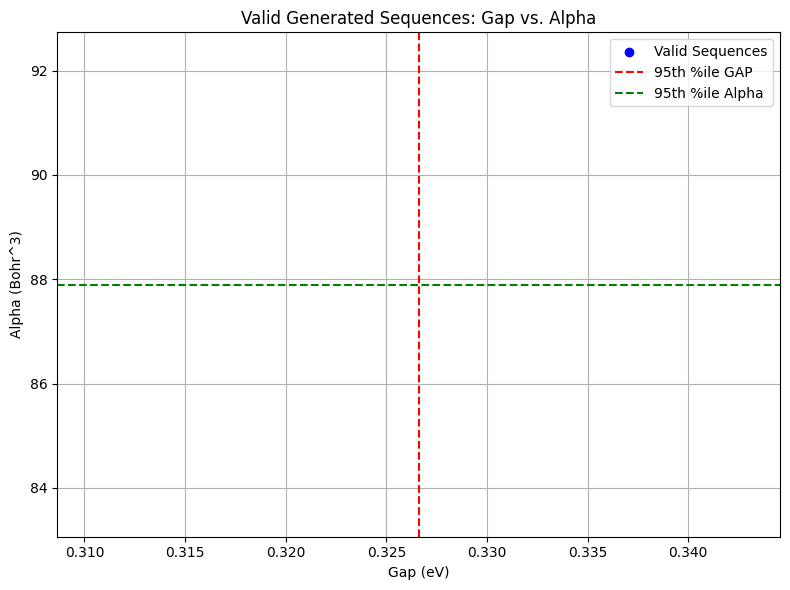

In [57]:
import random

# Number of sequences to generate
x = 100

# Get statistics from full dataset for generating random properties
homo_range = (df_full['homo'].min(), df_full['homo'].max())
lumo_range = (df_full['lumo'].min(), df_full['lumo'].max())
alpha_range = (df_full['alpha'].min(), df_full['alpha'].max())

# High-performing cutoffs (you already calculated these)
high_gap_target = df_full['gap'].quantile(0.95)
high_alpha_target = df_full['alpha'].quantile(0.95)

# 1. Generate random property sets
target_properties_list_unscaled = []

for _ in range(x):
    # 20% chance to sample from high-performing region
    if random.random() < 0.2:
        homo = random.uniform(-3.0, -1.5)
        lumo = random.uniform(2.0, 3.0)
        alpha = random.uniform(high_alpha_target, alpha_range[1])
    else:
        homo = random.uniform(*homo_range)
        lumo = random.uniform(*lumo_range)
        alpha = random.uniform(*alpha_range)

    # Ensure physical plausibility: LUMO > HOMO
    if lumo <= homo:
        lumo = homo + abs(np.random.normal(2.5, 0.5))  # Add positive gap

    gap = lumo - homo
    target_properties_list_unscaled.append({
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'alpha': alpha
    })

# 2. Generate new sequences using the existing pipeline
generated_smiles_info = generate_new_sequences(
    model, 
    tokenizer, 
    scaler,
    target_properties_list_unscaled,
    qm9_smiles_set,
    property_cols
)

# 3. Filter valid sequences
valid_sequences = [
    info for info in generated_smiles_info 
    if info.get('valid', False)
]

# 4. Plot GAP vs. Alpha for valid sequences
gaps = [entry['target_properties']['gap'] for entry in valid_sequences]
alphas = [entry['target_properties']['alpha'] for entry in valid_sequences]

plt.figure(figsize=(8, 6))
plt.scatter(gaps, alphas, color='blue', label='Valid Sequences')

# Vertical lines for maximum values
plt.axvline(x=high_gap_target, color='red', linestyle='--', label='95th %ile GAP')
plt.axhline(y=high_alpha_target, color='green', linestyle='--', label='95th %ile Alpha')

plt.xlabel('Gap (eV)')
plt.ylabel('Alpha (Bohr^3)')
plt.title('Valid Generated Sequences: Gap vs. Alpha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('target_properties_plot.png')
plt.show()


In [58]:
def generate_and_evaluate_high_performers(
    generative_model, # Your SmilesTransformer (Property -> SMILES)
    forward_model,    # Your TransformerRegressor (SMILES -> Property), wrapped
    tokenizer,
    scaler,           # Scaler fitted on property_column_names from the full dataset distribution
    full_dataset_df,  # The complete QM9 dataframe (unscaled, unfiltered)
    property_column_names, # e.g., ['homo', 'lumo', 'gap', 'alpha']
    device,
    max_seq_len,
    target_property_names=['alpha', 'gap'],
    percentile_threshold=0.90,
    generation_target_multiplier=1.1,
    num_generations=100, # Number of generation attempts
    output_csv_path="high_performing_generated_smiles.csv"
):
    """
    Generates new SMILES aiming for high performance in specified target properties,
    evaluates them using a forward model, and stores high performers in a CSV.
    """
    print(f"\n--- Generating and Evaluating High-Performing SMILES ---")
    print(f"Targeting high values for: {', '.join(target_property_names)}")
    print(f"Attempting {num_generations} generations.")

    if full_dataset_df.empty:
        print("Full dataset is empty, cannot establish baseline performance. Aborting.")
        return None

    performance_thresholds = {}
    dataset_means = {}

    for prop_name in property_column_names:
        if prop_name not in full_dataset_df.columns:
            print(f"Warning: Property '{prop_name}' not found in full_dataset_df. Skipping for baseline.")
            dataset_means[prop_name] = 0.0 # Fallback
            continue
        
        prop_values_no_nan = full_dataset_df[prop_name].dropna()
        if prop_values_no_nan.empty:
            print(f"Warning: Property '{prop_name}' has no valid data after dropping NaNs.")
            dataset_means[prop_name] = 0.0
            if prop_name in target_property_names:
                 performance_thresholds[prop_name] = 0.0
            continue
            
        dataset_means[prop_name] = prop_values_no_nan.mean()
        if prop_name in target_property_names:
            threshold = prop_values_no_nan.quantile(percentile_threshold)
            performance_thresholds[prop_name] = threshold
            print(f"Targeting {prop_name} > {threshold:.4f} ({percentile_threshold*100:.0f}th percentile of dataset)")

    if not any(p in performance_thresholds for p in target_property_names):
        print("Could not determine performance thresholds for any target properties. Aborting.")
        return None

    input_props_for_generation_unscaled = pd.Series(index=property_column_names, dtype=float)
    print("\nInput properties for generation (unscaled, before scaling):")
    for prop_name in property_column_names:
        if prop_name in target_property_names and prop_name in performance_thresholds:
            target_val = performance_thresholds[prop_name] * generation_target_multiplier
            input_props_for_generation_unscaled[prop_name] = target_val
            print(f"  Targeting {prop_name}: {target_val:.4f}")
        elif prop_name in dataset_means:
            input_props_for_generation_unscaled[prop_name] = dataset_means[prop_name]
            print(f"  Using mean for {prop_name}: {dataset_means[prop_name]:.4f}")
        else:
            input_props_for_generation_unscaled[prop_name] = 0.0 # Fallback
            print(f"  Using fallback 0.0 for {prop_name}")


    try:
        unscaled_props_df = pd.DataFrame([input_props_for_generation_unscaled.values], columns=property_column_names)
        # Ensure scaler was fitted with feature names if unscaled_props_df has them
        if hasattr(scaler, 'feature_names_in_') and isinstance(unscaled_props_df, pd.DataFrame):
             unscaled_props_df.columns = scaler.feature_names_in_
        scaled_props_numpy = scaler.transform(unscaled_props_df)
    except Exception as e:
        print(f"Error scaling target properties for generation: {e}")
        return None

    squeezed_props = scaled_props_numpy.squeeze()
    if squeezed_props.ndim == 0: # handles single property case
        scaled_props_tensor = torch.tensor([squeezed_props.item()], dtype=torch.float).to(device)
    else:
        scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(device)


    high_performers_list = []
    generated_smiles_set = set()

    generative_model.eval()
    if hasattr(forward_model, 'eval'): forward_model.eval()

    for i in range(num_generations):
        if (i + 1) % (num_generations // 10 if num_generations >= 10 else 1) == 0:
            print(f"Generation attempt {i+1}/{num_generations}...")

        with torch.no_grad():
            # The generative_model.generate method should match the one in your cell 26 or cell 14.
            # It takes (properties_tensor, tokenizer, max_len)
            generated_smiles = generative_model.generate(scaled_props_tensor, tokenizer, max_len=max_seq_len)

        if not generated_smiles or pd.isna(generated_smiles) or generated_smiles.strip() == "" or generated_smiles == tokenizer.pad_idx: # Check against actual pad token if it's a char
            # print(f"  Attempt {i+1}: Empty or invalid SMILES generated. Skipping.") # Optional: for verbosity
            continue
        
        if generated_smiles in generated_smiles_set:
            continue
        generated_smiles_set.add(generated_smiles)

        mol = None
        if RDKIT_AVAILABLE:
            mol = Chem.MolFromSmiles(generated_smiles)
            if not mol:
                # print(f"  SMILES: {generated_smiles} - Invalid (RDKit). Skipping.") # Optional
                continue
        
        try:
            # forward_model.predict_properties(smiles_string) returns a dict of *unscaled* properties
            predicted_props_dict_unscaled = forward_model.predict_properties(generated_smiles)

            if not isinstance(predicted_props_dict_unscaled, dict):
                 print(f"  Forward model for {generated_smiles} did not return a dict. Skipping.")
                 continue

            is_high_performer = True
            for prop_name in target_property_names:
                if prop_name not in predicted_props_dict_unscaled or pd.isna(predicted_props_dict_unscaled[prop_name]):
                    is_high_performer = False; break
                if predicted_props_dict_unscaled[prop_name] <= performance_thresholds.get(prop_name, float('inf')):
                    is_high_performer = False; break
            
            if is_high_performer:
                print(f"  Generated High-Performer: {generated_smiles}")
                entry = {"smiles": generated_smiles}
                for p_name in property_column_names: # Save all relevant properties
                    entry[p_name] = predicted_props_dict_unscaled.get(p_name, np.nan)
                high_performers_list.append(entry)

        except Exception as e:
            print(f"  Error during forward model prediction for {generated_smiles}: {e}")
            continue

    if high_performers_list:
        high_performers_df = pd.DataFrame(high_performers_list)
        output_columns_ordered = ['smiles'] + [p for p in property_column_names if p in high_performers_df.columns]
        high_performers_df = high_performers_df[output_columns_ordered]
        
        os.makedirs(os.path.dirname(output_csv_path) or '.', exist_ok=True)
        high_performers_df.to_csv(output_csv_path, index=False)
        print(f"\nSuccessfully saved {len(high_performers_df)} high-performing SMILES to {output_csv_path}")
        if not high_performers_df.empty:
            print("\nTop few high performers:")
            print(high_performers_df.head())
        return high_performers_df
    else:
        print("\nNo high-performing SMILES were generated and validated that met the criteria.")
        return pd.DataFrame()